In [36]:
#I am creating this model to verify the field equations(amp, phase) modelled by me, with the results from finesse3.
import finesse
finesse.configure(plotting=True)
sm=finesse.Model()
sm.parse("""
l laser1 P=1 

#s s0 laser1.p1 md.p1 L=0
#mod md midx=1 order=1 f=0.375e8
                               # I was trying to understand what happens when the RF sidebands are resonant or anti-res in the 
                               #PRC.
                               #For this verification, I have commented them to avoid the sidebands.

s s1 laser1.p1 pr.p1 L=0

m pr R=0.9 T=0.1            
s PRC pr.p2 bs1.p1 L=1
bs bs1 R=0.5 T=0.5  

s Lx bs1.p3 ETMx.p1 L=1   
m ETMx R=1 T=0 phi=90           #setting the asymmetric port dark.

s Ly bs1.p2 ETMy.p1 L=1
m ETMy R=1 T=0 

ad circ_i pr.p2.o f=0           #computing the field at the output of power_recylcing mirror.

xaxis(pr.phi,lin,-180,180,1000) #Tuning the Power_recycling mirror from -lambda/2 to lambda/2
""")

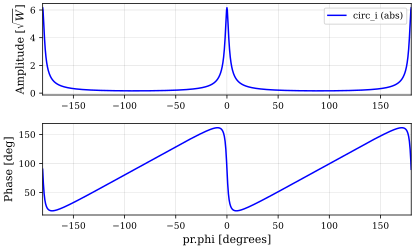

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'circ_i': <Figure size 576x355.968 with 2 Axes>}

In [27]:
out=sm.run()
out.plot()

The Circulated field at the output of the second port of the power recycling mirror came out to be 
$\frac{it_{PR}E_{1}}{1-r_{PR}r_{sm}e^{-2ikl_{p}}}$<br>
where $r_{sm}$ is the complex reflectivity of a simple michelson set-up with 50-50 beam splitter and perfectly reflecting end mirrors, and is given by $i\sin{k(l_{x}-l_{y})}$<br><br>
By default, $E_{1}$ is taken as a reference with amplitude equal to $\sqrt{P_{laser}}$, hence here it equals $E_{1}=1$ (a real field because it is taken as the reference with zero phase change).

Text(0.5, 0, 'pr.phi($^{o}$)')

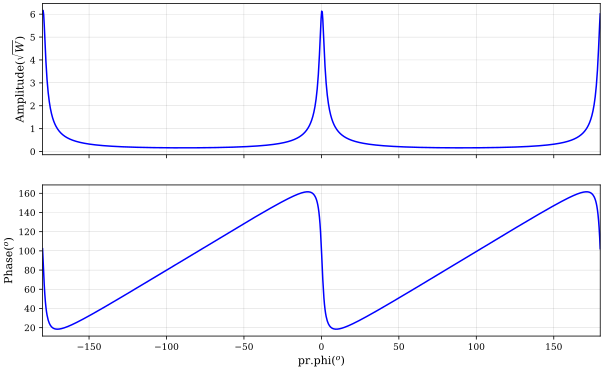

In [30]:
#In this cell, I am plotting the Circulated field that I get mathematically.
import matplotlib.pyplot as plt
import numpy as np
phi=np.linspace(-180,180,1000)
k=2*np.pi/1064E-9
E=1j*np.sqrt(0.1)/(1-np.sqrt(0.9)*1j*np.sin(np.pi/2)*np.exp(-2j*(k*1+np.pi*phi/180)))

#In the sine term, the l_x-l_y=0 but it is tuned by pi/2, also in the exponential term, the initial l_p is also accounted, 
#along with the tuning of the power recycling mirror.

phs=180*np.angle(E)/np.pi
#plotting
figure, a=plt.subplots(2,sharex=True,figsize=(10,6))
a[0].plot(phi,abs(E))
a[0].set_ylabel("Amplitude($\sqrt{W}$)")
a[1].plot(phi,phs)
a[1].set_ylabel("Phase($^{o}$)")
a[1].set_xlabel("pr.phi($^{o}$)")

#the results were matching with the ones that came out from finesse.

Next, I am fixing the lp and changing the MICH (lx-ly), out of the two terms lx and ly, I have fixed lx and changed the ly by tuning the ETMy mirror. I have added a fixed tuning to the ETMx to make the asymmetric port dark initially. 

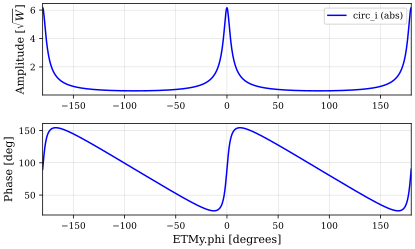

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'circ_i': <Figure size 576x355.968 with 2 Axes>}

In [29]:
sm.parse("xaxis(ETMy.phi,lin,-180,180,1000)")
out=sm.run()
out.plot()

(50.0, 180.0)

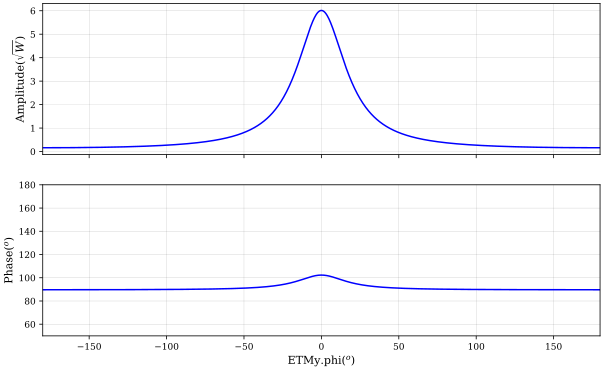

In [34]:
import matplotlib.pyplot as plt
import numpy as np
phi=np.linspace(-180,180,1000)
k=2*np.pi/1064E-9

E=1j*np.sqrt(0.1)/(1-np.sqrt(0.9)*1j*np.sin(np.pi/2-np.pi*phi/180)*np.exp(-2j*k*1))

#k(l_x-l_y) term accounts for the initial tuning of ETMx and the tuning of the ETMy, which changes the MICH (lx-ly).

phs=180*np.angle(E)/np.pi
#plotting
figure, a=plt.subplots(2,sharex=True,figsize=(10,6))
a[0].plot(phi,abs(E))
a[0].set_ylabel("Amplitude($\sqrt{W}$)")
a[1].plot(phi,phs)
a[1].set_ylabel("Phase($^{o}$)")
a[1].set_xlabel("ETMy.phi($^{o}$)")
a[1].set_ylim(50,180)

#the results were not matching with the ones that came out from finesse.

The same field equation gave the correct results in the first case and did not work in the second case. I was worried if my field equations were right, but after going through it a couple of times, I believe they are right and now I am confused about these results.